In [11]:
#Imports
import torch
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch import nn
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook as tqdm
#tqdm().pandas()

<h3>Config for model

In [46]:
positive_sample_size = 2000
negative_sample_size = 2000
positive_test_sample_size = 300
negative_test_sample_size = 300
window_size = 3
embedding_size = 5
num_epochs = 100
batch_size = 50
hidden_layer_size = 500
hidden_layer_size_2 = 500
with_attention = True
learning_rate = 0.01
model_name = 'fc_with_attention.pt'
test_model_name = 'fc_with_attn_per_epoch.pt'

<h3>Loading data for basic model

In [47]:
positive_data = pd.read_csv('positive_sample.txt', header = None, nrows = positive_sample_size)
positive_data.columns = ["Gene"]
negative_data = pd.read_csv('negative_sample.txt', header = None, nrows = negative_sample_size)
negative_data.columns = ["Gene"]
positive_test_data = pd.read_fwf('positive_sample_test.txt', header = None)
positive_test_data.columns = ["Gene"]
negative_test_data = pd.read_fwf('negative_sample_test.txt', header = None)
negative_test_data.columns = ["Gene"]
train_data = positive_data.append(negative_data)
test_data = positive_test_data.append(negative_test_data)

#print(data.head(2))

In [48]:
train_data.shape

(4000, 1)

<h3>Helper methods for the model

In [49]:
#Helper methods
def get_labels(positive_sample_size, negative_sample_size):
    #labels = []
    #positive_
    labels = torch.cat((torch.ones([positive_sample_size, 1], dtype=torch.float), torch.zeros([negative_sample_size, 1], dtype=torch.float)))
    #print(labels)
    return labels
def embeddings_helper(window_size):
    vocab_set = set()
    def generate_vocab_helper(set, k): 
        n = len(set)  
        generate_vocab(set, "", n, k) 
    def generate_vocab(set, prefix, n, k): 
        if (k == 0) : 
            vocab_set.add(prefix)
            return
        for i in range(n): 
            newPrefix = prefix + set[i] 
            generate_vocab(set, newPrefix, n, k - 1) 
    def generate_embed_map(n):
        alphabet = ['0','1','2','3','4']
        generate_vocab_helper(alphabet, n)

        vocab_set_1 = sorted(vocab_set)
        vocab_map = {}

        for i in range(len(vocab_set_1)):
            vocab_map[vocab_set_1[i]] = i
        return vocab_map
    return generate_embed_map(window_size)

def return_embeddings(vocabulary):
    embeds = nn.Embedding(len(vocabulary), embedding_size)
    embeddings = {}
    for word in vocabulary:
        embeddings[word] = embeds(torch.tensor(vocabulary[word], dtype=torch.long))
    return embeddings

#ATG, GTG, TTG
def is_start_codon(codon):
    start_codons = ['143', '343', '443']#['ATG', 'GTG', 'TTG']
    if codon in start_codons:
        return True
    return False

<h3>Create training data with training inputs and labels

In [50]:
def create_vocabulary(window_size):
    return embeddings_helper(window_size)

def get_inputs_and_labels(datapoints, positive_sample_size, negative_sample_size):
    # In an array, place 1s for codons that match the start pattern and 0s for codons that do not.
    #Creating word indexes for permutations of protein bases (words of vocabulary)
    vocabulary = create_vocabulary(window_size)
    inputs = []
    for data in datapoints.itertuples():
        gene = data.Gene
        input = torch.tensor([vocabulary[gene[i:i+window_size]] for i in range(0, len(gene) - window_size + 1)], dtype=torch.long)
        inputs.append(input)
    labels = get_labels(positive_sample_size, negative_sample_size)
    return inputs, labels

<h3> Implementing the FC Layer

In [51]:
class Attention_Net(nn.Module):
    def __init__(self):
        super(Attention_Net, self).__init__()
        #embeds are of the dimension n * (1 x (embedding_size * no_of_kmers))
        self.embeds = nn.Embedding(len(create_vocabulary(window_size)), embedding_size)
        self.embeds_size = embedding_size*(len(positive_data.Gene[0]) - window_size + 1)
        #self.attn_weights = nn.Parameter(torch.randn(embeds_size, embeds_size))
        self.tanh = torch.tanh
        self.fc1 = nn.Linear(self.embeds_size, hidden_layer_size)
        self.relu = F.relu
        self.sigmoid = nn.Sigmoid()
        #self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size_2)
        #self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size_2)
        self.fc2 = nn.Linear(hidden_layer_size, 1)
        #self.out = nn.Linear(hidden_layer_size_2, 1)

    def forward(self, inputs):
        embedding_weights = self.embeds(inputs).view((1,-1))
        attn_weights = autograd.Variable(torch.randn(self.embeds_size, self.embeds_size))
        transformation = self.tanh(torch.mm(embedding_weights, attn_weights))
        context = self.sigmoid(transformation)
        
#         print(embedding_weights.shape)
#         print(context.shape)
        
        attended_inputs = embedding_weights * context
        layer1 = self.fc1(attended_inputs)
        act1 = self.relu(layer1)
        #dout = self.dout(h1)
        layer2 = self.fc2(act1)
        act2 = self.relu(layer2)
        #layer3 = self.out(act2)
        #act3 = self.relu(layer3)
        #output = self.sigmoid(act3)
        output = self.sigmoid(act2)
        return output
    
def train_epoch(model, inputs, labels, optimizer, criterion):
    model.train()
    losses = []
    vocabulary = create_vocabulary(window_size)
    labels_hat = []
    j = 0
    correct, wrong = 0,0
    for data in inputs.itertuples():
        gene = data.Gene
        input_ = torch.tensor([vocabulary[gene[i:i+window_size]] for i in range(0, len(gene) - window_size + 1)], dtype=torch.long)
        #data_batch = inputs[i:i + batch_size, :]
        #labels_batch = labels[i:i + batch_size, :]
        inputs = autograd.Variable(input_)
        label = autograd.Variable(labels[j])
        j += 1
        optimizer.zero_grad()
        # (1) Forward
        label_hat = model(input_)
        # (2) Compute diff
        loss = criterion(label_hat, label)
        # (3) Compute gradients
        losses.append(loss.data.numpy())
        loss.backward(retain_graph = False)
        # (4) update weights
        optimizer.step()        
        labels_hat.append(label_hat)
        correct, wrong = get_train_accuracy(label_hat, j-1, len(labels), correct, wrong)
        

    #print('labels_hat size>', len(labels_hat))
    loss = sum(losses)/len(losses)
    
    return loss, labels_hat, tuple((correct, wrong))
    
def train_model(model, optimizer, criterion, with_attention):
    losses = []
    labels_hat = []
    print('Training the model:')
    start_time = time.time()
    train_accuracies, test_accuracies = [], []
    test_labels = get_labels(positive_test_sample_size, negative_test_sample_size)
    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
        inputs = train_data
        labels = get_labels(positive_sample_size, negative_sample_size)
        loss, labels_hat, acc = train_epoch(model, inputs, labels, optimizer, criterion)

        losses.append(loss)
        #labels_hat.append(label_hat)
        #accuracy
        train_accuracy = 100*(acc[0]/(acc[0]+acc[1]))
        train_accuracies.append(train_accuracy)
        torch.save(model.state_dict(), test_model_name)
        test_accuracy = test(test_data, test_labels, test_model_name)
        test_accuracies.append(test_accuracy)
    torch.save(model.state_dict(), model_name)
    print('Finished. Training took %.3f' %((time.time() - start_time)/60), 'minutes.')
    return losses, train_accuracies, test_accuracies

In [52]:
attn_net = Attention_Net()
print(attn_net)

Attention_Net(
  (embeds): Embedding(125, 5)
  (fc1): Linear(in_features=495, out_features=500, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=500, out_features=1, bias=True)
)


In [53]:
def train():
    fcNet = Attention_Net()
    #inputs, labels = get_inputs_and_labels(train_data, positive_sample_size, negative_sample_size)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(fcNet.parameters(), lr=0.01, momentum=0.0)
    losses, train_accuracies, test_accuracies = train_model(fcNet, optimizer, criterion, with_attention)
    #print('Losses>', losses)
    if losses != None:
        plt.plot(losses)
        title = 'Loss vs Epochs for: ' + (str)(positive_sample_size + negative_sample_size) + ' data points and ' + (str)(num_epochs) + ' epochs'
        plt.title(title)
    return train_accuracies, test_accuracies
        
        
def test(inputs, labels, model_name):
    model = Attention_Net()
    model.load_state_dict(torch.load(model_name))
    model.eval()
    labels_hat = []
    j=0
    vocabulary = create_vocabulary(window_size)
    for data in inputs.itertuples():
        gene = data.Gene
        input_ = torch.tensor([vocabulary[gene[i:i+window_size]] for i in range(0, len(gene) - window_size + 1)], dtype=torch.long)
        j += 1
        label_hat = model(input_)
        labels_hat.append(label_hat)
        
    accuracy = get_test_accuracy(labels_hat)
    return accuracy
    
def get_train_accuracy(label, index, data_size, correct, wrong):    
    if index < data_size/2+1:
        if label > 0.5:
            correct += 1
        else:
            wrong += 1
    else:
        if label > 0.5:
            wrong += 1
        else:
            correct += 1
    return correct, wrong

def get_test_accuracy(labels_hat):
    correct, wrong = 0, 0
    for i in range(len(labels_hat)//2 + 1):
        if labels_hat[i] > 0.5:
            correct += 1
        else:
            wrong += 1
    for i in range(len(labels_hat)//2 + 1, len(labels_hat)):
        if labels_hat[i] > 0.5:
            wrong += 1
        else:
            correct += 1
    accuracy = 100 * (correct/(correct+wrong))
    return accuracy




************************************************************************************************************

Training the model:



Finished. Training took 21.520 minutes.


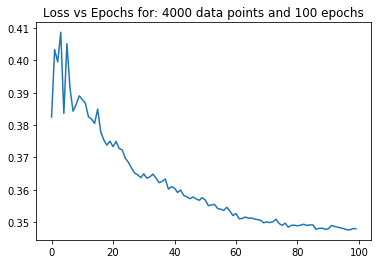

In [54]:
train_accuracies, test_accuracies = train()

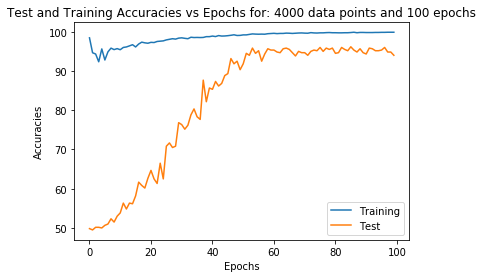

In [55]:
if train_accuracies != None and test_accuracies != None:
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')
    plt.plot(train_accuracies)
    plt.plot(test_accuracies)
    plt.gca().legend(('Training', 'Test'))
    
    title = 'Test and Training Accuracies vs Epochs for: ' + (str)(positive_sample_size+negative_sample_size) + ' data points and ' + (str)(num_epochs) + ' epochs'
    plt.title(title)


************************************************************************************************************

In [56]:
test_labels = get_labels(positive_test_sample_size, negative_test_sample_size)
test_accuracy = test(test_data, test_labels, model_name)
print('Training accuracy for the trained model is: ', train_accuracies[len(train_accuracies)-1])
print('Overall Test Accuracy is: ' , test_accuracy)

Training accuracy for the trained model is:  99.875
Overall Test Accuracy is:  94.66666666666667
